In [2]:
import torch
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, infer_device

c:\Study\Masters\term_3\CV-Workout-Tracker\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
model_id = "IDEA-Research/grounding-dino-tiny"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

In [9]:
def detect(image_name, text_labels):
    image = Image.open(image_name)
    inputs = processor(images=image, text=text_labels, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=0.5,
        text_threshold=0.3,
        target_sizes=[image.size[::-1]]
    )

    colors = ["red", "blue", "green", "yellow", "purple", "orange", "cyan", "magenta"]
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.imshow(image)

    result = results[0]
    for i, (box, score, label) in enumerate(zip(result["boxes"], result["scores"], result["labels"])):
        box = [round(x, 2) for x in box.tolist()]
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=3,
            edgecolor=colors[i % len(colors)],
            facecolor='none'
        )
        ax.add_patch(rect)

        label_text = f"{label}: {score:.2f}"
        ax.text(
            box[0], box[1] - 10,
            label_text,
            color=colors[i % len(colors)],
            fontsize=12,
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor=colors[i % len(colors)])
        )

        print(f"Detected {label} with confidence {round(score.item(), 3)} at location {box}")

    ax.axis('off')
    plt.tight_layout()
    plt.show()

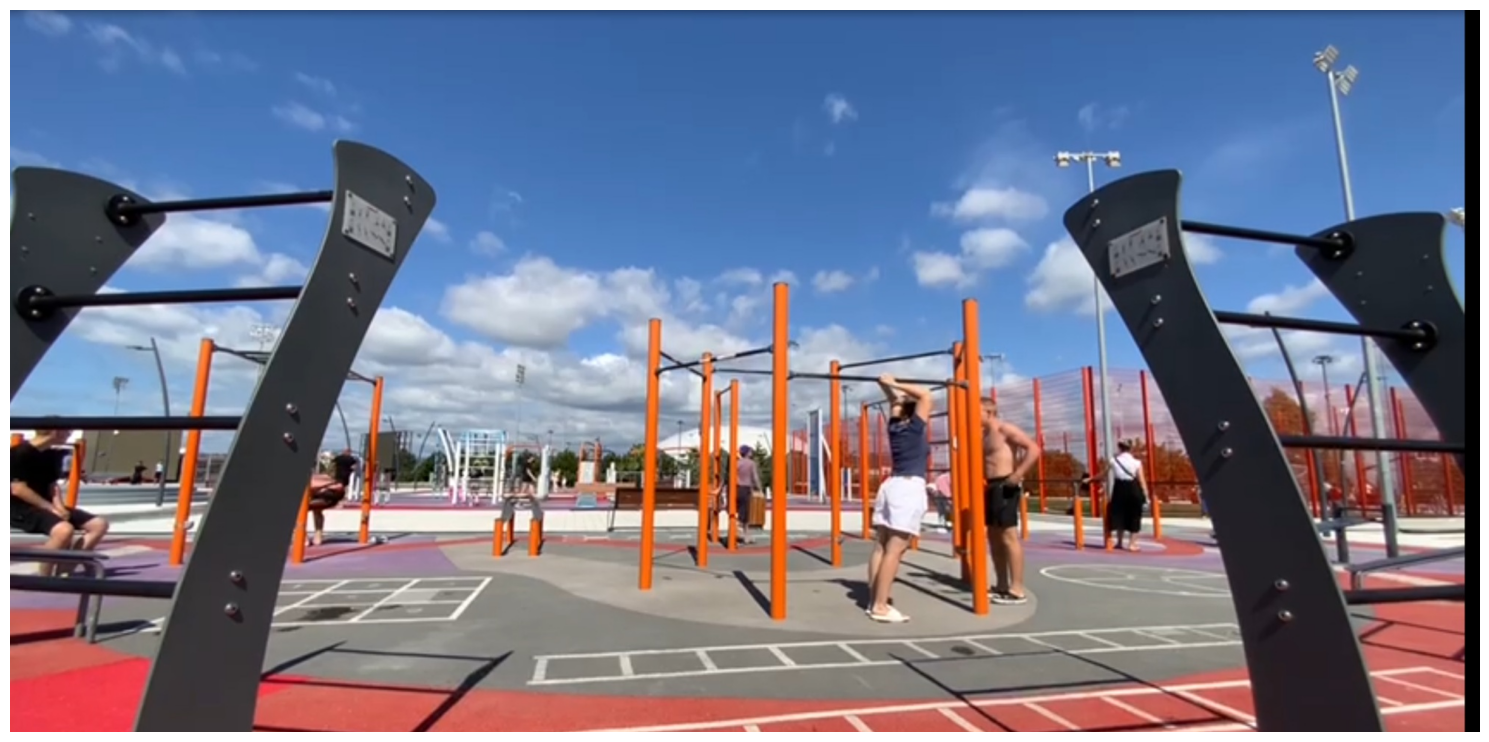

In [10]:
image_name = "custom_dataset/example1.jpg"
text_labels = [["horizontal bar"]]
detect(image_name, text_labels)

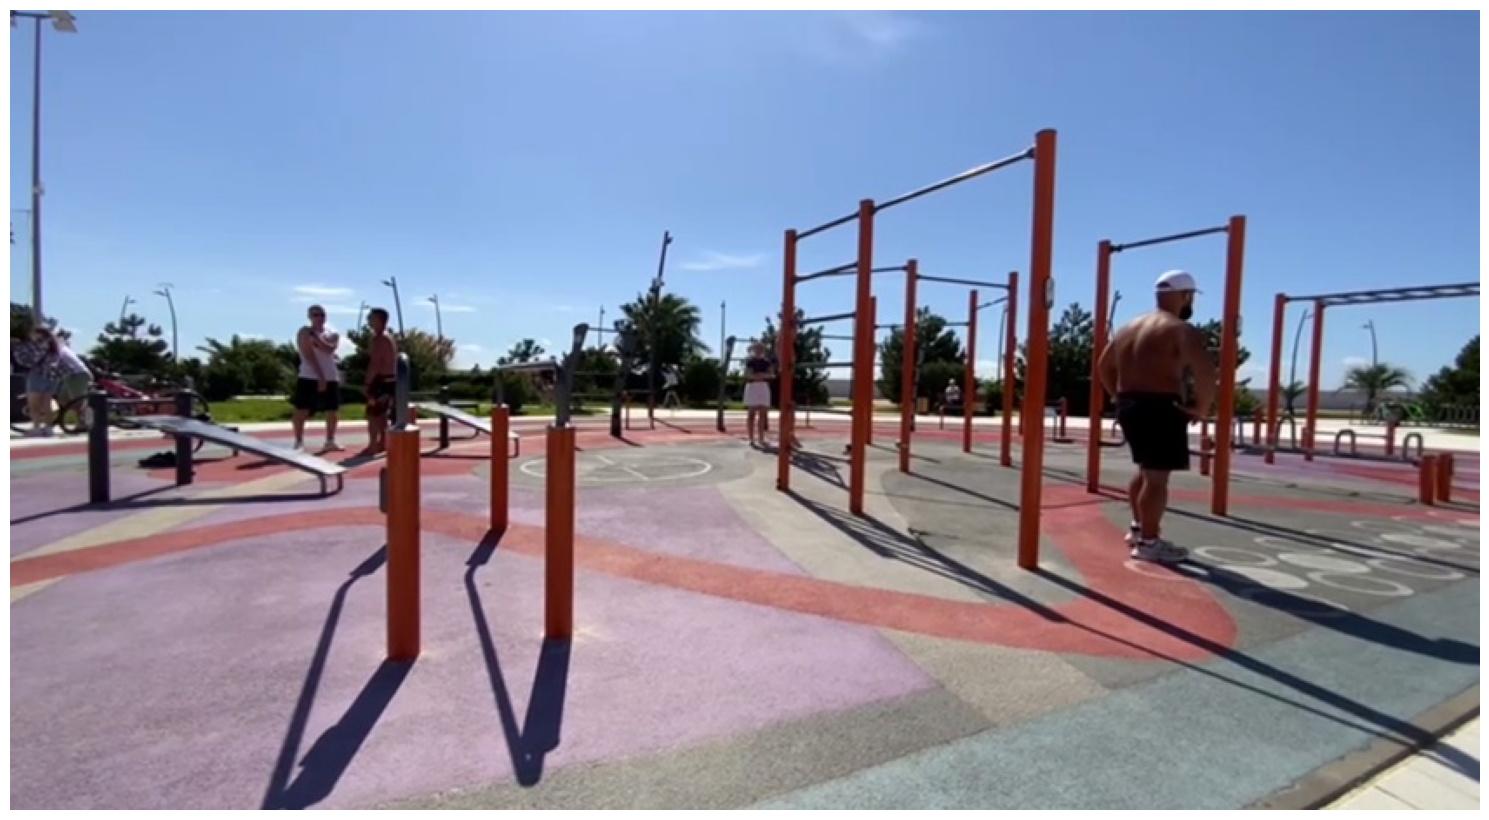

In [11]:
image_name = "custom_dataset/example2.jpg"
text_labels = [["horizontal bar", "bench"]]
detect(image_name, text_labels)